# Comparing energy maps

- carlos: `map_4bar_1506.h5`
- gonzalo: `rough_geometry_map_v0.h5`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


In [2]:
run = 15107

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
2,275,1.742935e+09,0,0,1,1,375.0,20.105528,130.680893,1217525.0,...,2539,185.960632,185.960632,18.371055,15.761644,-65.178615,67.057299,-1.333529,190.955556,208.454665
14,590,1.742935e+09,0,0,1,1,400.0,41.841473,240.074432,1139325.0,...,2969,266.157379,266.157379,29.010471,170.053074,19.509000,171.168482,0.114224,217.766683,168.386432
15,597,1.742935e+09,0,0,1,1,650.0,16.592751,97.683167,493475.0,...,2261,919.024780,919.024780,9.251109,75.948209,52.021293,92.056208,0.600559,214.760246,197.605371
20,1556,1.742935e+09,0,0,1,1,350.0,17.792589,102.266724,530275.0,...,2102,877.213196,877.213196,8.832326,110.182593,3.345906,110.233384,0.030358,237.921637,199.830332
25,1794,1.742935e+09,0,0,1,1,275.0,21.349106,106.103920,877900.0,...,2550,531.588501,531.588501,8.046095,108.494903,87.064883,139.109446,0.676251,240.576917,220.669800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25147,658454,1.742944e+09,0,0,1,1,375.0,10.825253,69.822937,1202675.0,...,2851,205.808258,205.808258,9.201199,15.608674,98.721551,99.947863,1.413986,224.630671,251.603989
25152,658699,1.742944e+09,0,0,1,1,575.0,16.538542,87.122505,839450.0,...,2870,567.041748,567.041748,12.670540,40.841408,-8.578211,41.732557,-0.207028,226.215802,217.065314
25153,658923,1.742944e+09,0,0,1,1,625.0,15.709264,91.425804,1274300.0,...,2163,129.195633,129.195633,18.046918,86.402601,-24.296199,89.753634,-0.274119,203.298461,188.980867
25160,1074513,1.742949e+09,0,0,1,1,350.0,19.289764,105.112312,792425.0,...,2470,616.065002,616.065002,13.975123,-3.418172,-1.705237,3.819913,-2.678846,203.424014,201.055704


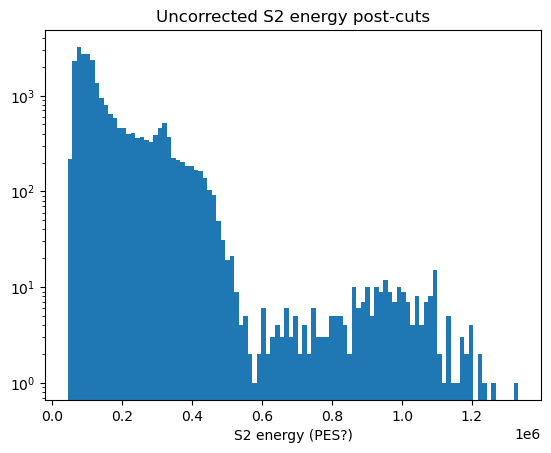

In [10]:
# LOAD IN OLD DSTS
OLD_DST = pd.read_hdf('files/DST_15107_passing.h5', key = 'DST/Events')
display(OLD_DST)

plt.hist(OLD_DST.S2e.values, bins = 100)#, range = [0, 5e5])
plt.title('Uncorrected S2 energy post-cuts')
plt.yscale('log')
plt.xlabel('S2 energy (PES?)')
plt.show()

# Load in RECO/Events

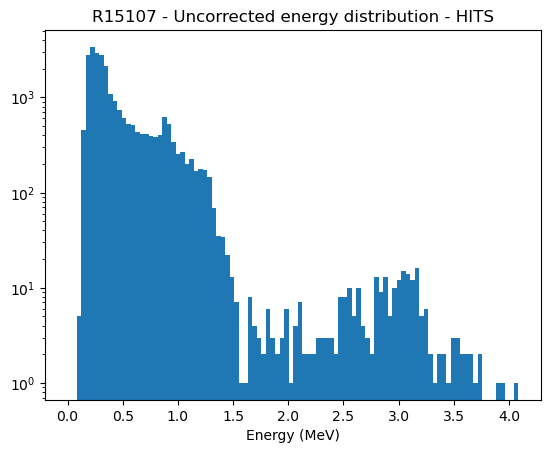

In [11]:
events_of_interest = OLD_DST.event.unique()

full_dst = pd.read_hdf('files/15107_merger_RECO.h5', key = 'RECO/Events')

plt.hist(full_dst.groupby('event').Ec.sum(), bins = 100, range = [0, max(full_dst.groupby('event').Ec.sum())])
plt.xlabel('Energy (MeV)')
plt.title(f'R{run} - Uncorrected energy distribution - HITS')
plt.yscale('log')
plt.show()

# Apply both correction

In [12]:
maps_carlos       = read_maps(os.path.expandvars('/gluster/data/next/files/TOPOLOGY_John/LPR/LightTables/map_4bar_15063.h5'))
maps_gonzalo       = read_maps(os.path.expandvars('/gluster/data/next/files/TOPOLOGY_John/LPR/LightTables/rough_geometry_map_v0.h5'))
apply_temp_c = False
apply_temp_g = False
norm_strat = NormStrategy.kr

get_coef_c  = apply_all_correction( maps_carlos
                                , apply_temp = apply_temp_c
                                , norm_strat = norm_strat
                                , norm_value = None)

get_coef_g  = apply_all_correction( maps_gonzalo
                                , apply_temp = apply_temp_g
                                , norm_strat = norm_strat
                                , norm_value = None)


#time_to_Z_c = get_df_to_z_converter(maps_carlos) if maps_carlos.t_evol is not None else identity
#time_to_Z_g = get_df_to_z_converter(maps_gonzalo) if maps_gonzalo.t_evol is not None else identity


In [13]:
# the XYZT values to correct
x_vals = full_dst.X.values
y_vals = full_dst.Y.values
z_vals = full_dst.Z.values
t_vals = full_dst.time.values

In [14]:
get_all_coefs_c = get_coef_c(x_vals, y_vals, z_vals, t_vals)
get_all_coefs_g = get_coef_g(x_vals, y_vals, z_vals, t_vals)


In [15]:
# correct those vals
e_corr_c = full_dst.E.values * get_all_coefs_c
full_dst['Ec'] = e_corr_c

e_corr_g = full_dst.E.values * get_all_coefs_g
full_dst['Eg'] = e_corr_g


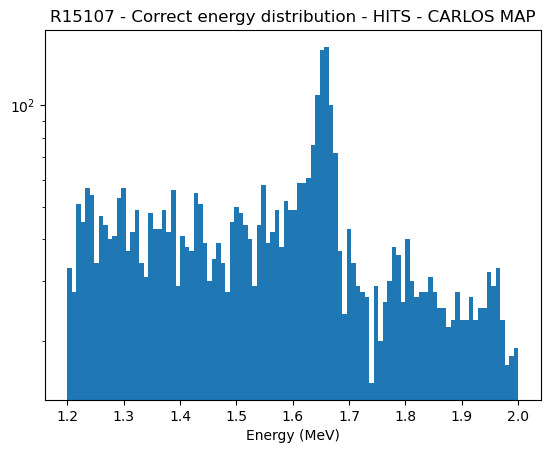

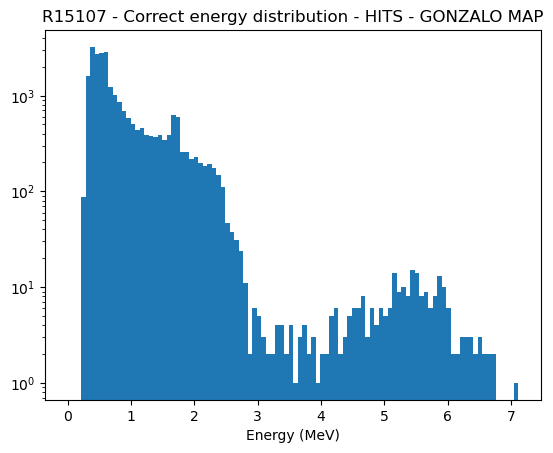

In [26]:
plt.hist(full_dst.groupby('event').Ec.sum(), bins = 100, range = [1.2, 2.0])
plt.xlabel('Energy (MeV)')
plt.title(f'R{run} - Correct energy distribution - HITS - CARLOS MAP')
plt.yscale('log')
plt.show()


plt.hist(full_dst.groupby('event').Eg.sum(), bins = 100, range = [0, max(full_dst.groupby('event').Ec.sum())])
plt.xlabel('Energy (MeV)')
plt.title(f'R{run} - Correct energy distribution - HITS - GONZALO MAP')
plt.yscale('log')
plt.show()



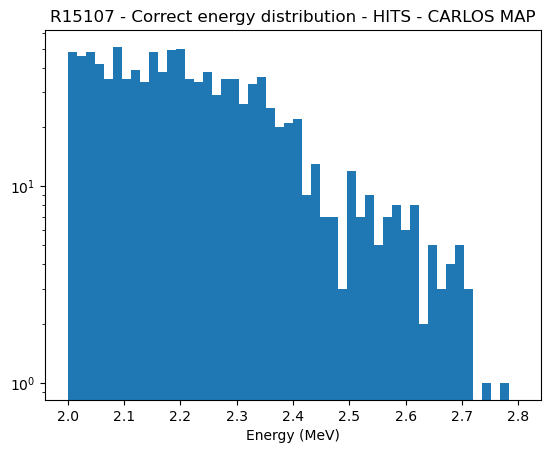

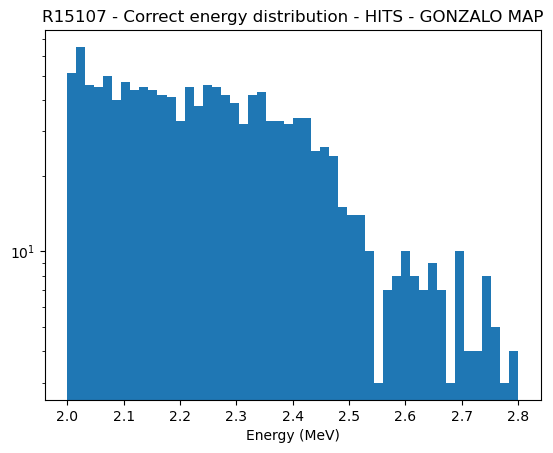

In [25]:
plt.hist(full_dst.groupby('event').Ec.sum(), bins = 50, range = [2, 2.8])
plt.xlabel('Energy (MeV)')
plt.title(f'R{run} - Correct energy distribution - HITS - CARLOS MAP')
plt.yscale('log')
plt.show()


plt.hist(full_dst.groupby('event').Eg.sum(), bins = 50, range = [2, 2.8])
plt.xlabel('Energy (MeV)')
plt.title(f'R{run} - Correct energy distribution - HITS - GONZALO MAP')
plt.yscale('log')
plt.show()

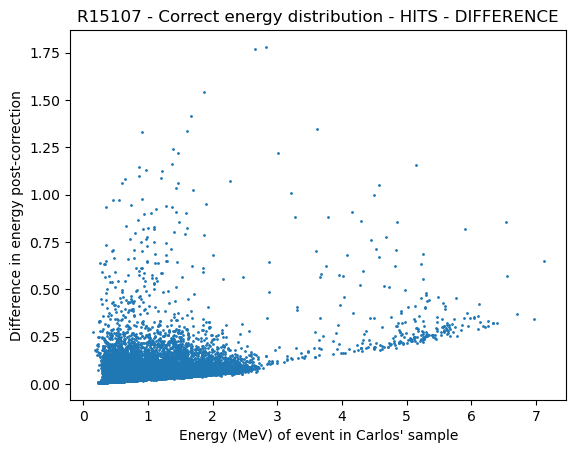

In [17]:
plt.scatter(full_dst.groupby('event').Ec.sum(), abs(full_dst.groupby('event').Ec.sum() - full_dst.groupby('event').Eg.sum()), s = 1)
plt.xlabel('Energy (MeV) of event in Carlos\' sample')
plt.ylabel('Difference in energy post-correction')
plt.title(f'R{run} - Correct energy distribution - HITS - DIFFERENCE')
#plt.yscale('log')
plt.show()

In [18]:
display(full_dst.groupby('event').Ec.sum())
display(full_dst.groupby('event').Eg.sum())
display(max(abs(full_dst.groupby('event').Eg.sum() - full_dst.groupby('event').Ec.sum())))

event
33         0.597372
178        0.610454
229        0.361373
275        0.746830
384        0.731150
             ...   
1543049    0.376550
1543072    0.274341
1543120    0.434331
1543210    0.518791
1543639    1.514616
Name: Ec, Length: 24826, dtype: float64

event
33         0.618085
178        0.625120
229        0.370448
275        0.769776
384        0.761798
             ...   
1543049    0.389245
1543072    0.285431
1543120    0.504809
1543210    0.535776
1543639    1.596012
Name: Eg, Length: 24826, dtype: float64

1.7810163579141625

,Z,Ec,Eg
event,,,
33,306.681625,0.597372,0.618085
178,361.450485,0.610454,0.625120
229,168.583517,0.361373,0.370448
275,214.866783,0.746830,0.769776
384,722.303399,0.731150,0.761798
...,...,...,...
1543049,605.460910,0.376550,0.389245
1543072,447.361135,0.274341,0.285431
1543120,-55.939550,0.434331,0.504809


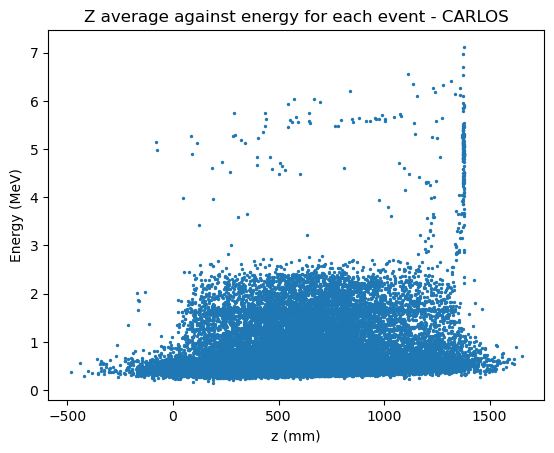

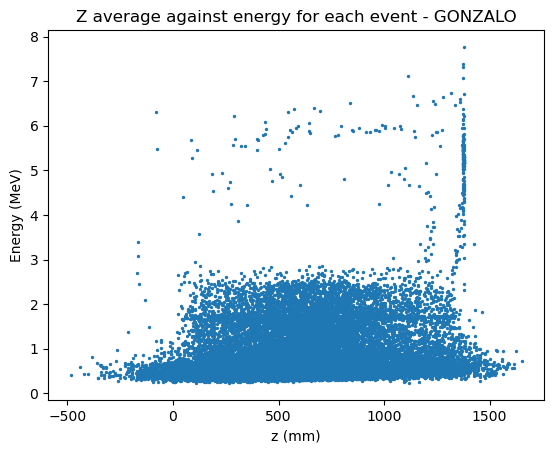

In [19]:
z_av_e_sum = full_dst.groupby('event').agg({'Z':'mean', 'Ec': 'sum', 'Eg': 'sum'})
display(z_av_e_sum)
plt.scatter(z_av_e_sum.Z.values, z_av_e_sum.Ec.values, s = 2)
plt.title('Z average against energy for each event - CARLOS')
plt.xlabel('z (mm)')
plt.ylabel('Energy (MeV)')
plt.show()


plt.scatter(z_av_e_sum.Z.values, z_av_e_sum.Eg.values, s = 2)
plt.title('Z average against energy for each event - GONZALO')
plt.xlabel('z (mm)')
plt.ylabel('Energy (MeV)')
plt.show()

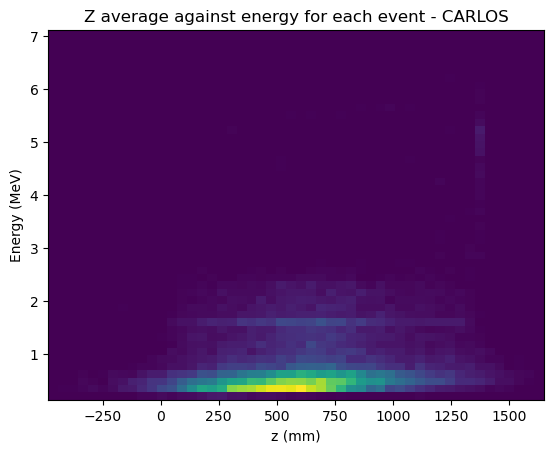

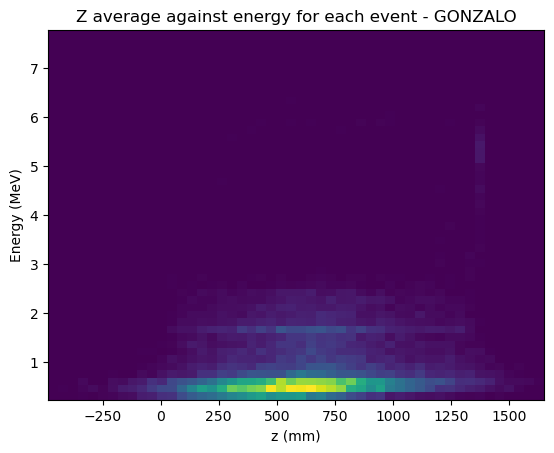

In [20]:


plt.hist2d(z_av_e_sum.Z.values, z_av_e_sum.Ec.values, bins = [50, 50])
plt.title('Z average against energy for each event - CARLOS')
plt.xlabel('z (mm)')
plt.ylabel('Energy (MeV)')
plt.show()


plt.hist2d(z_av_e_sum.Z.values, z_av_e_sum.Eg.values, bins = [50, 50])
plt.title('Z average against energy for each event - GONZALO')
plt.xlabel('z (mm)')
plt.ylabel('Energy (MeV)')
plt.show()

DEP events quickly

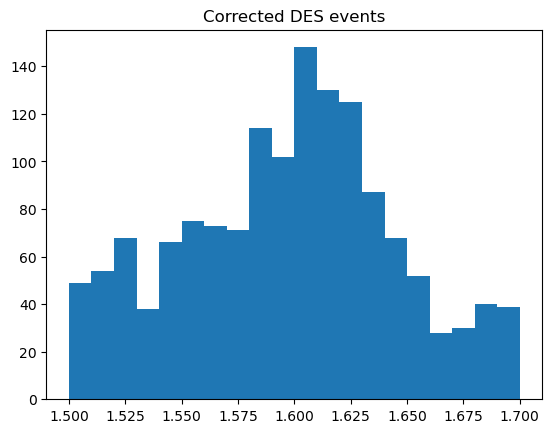

In [21]:
folder_path = 'files/15107_energy_split/'
corr_DES = pd.read_hdf(folder_path + 'corr_DES.h5', 'RECO/Events')

plt.hist(corr_DES.groupby('event').Ec.sum(), bins = 20, range = [1.5, 1.7])
plt.title('Corrected DES events')
plt.show()

In [22]:
# the XYZT values to correct
x_vals = corr_DES.X.values
y_vals = corr_DES.Y.values
z_vals = corr_DES.Z.values
t_vals = corr_DES.time.values
get_all_coefs_c = get_coef_c(x_vals, y_vals, z_vals, t_vals)
get_all_coefs_g = get_coef_g(x_vals, y_vals, z_vals, t_vals)

# correct those vals
e_corr_c = corr_DES.E.values * get_all_coefs_c
corr_DES['Ec'] = e_corr_c

e_corr_g = corr_DES.E.values * get_all_coefs_g
corr_DES['Eg'] = e_corr_g


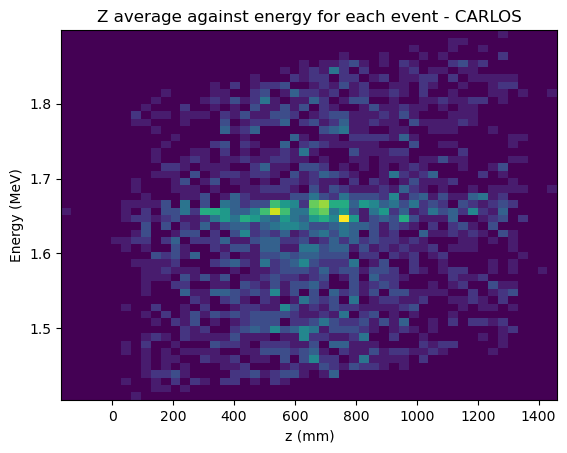

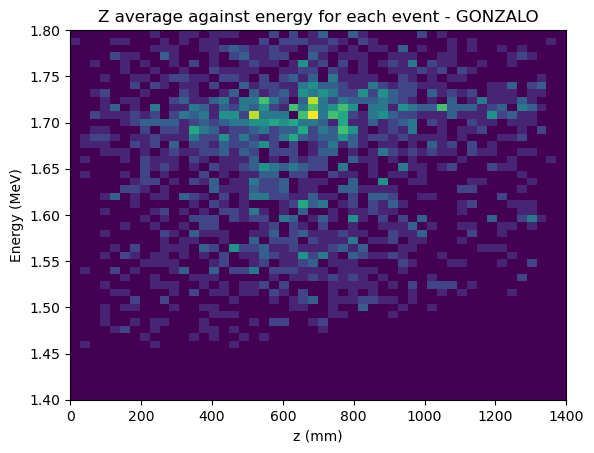

In [23]:
z_av_e_sum = corr_DES.groupby('event').agg({'Z':'mean', 'Ec': 'sum', 'Eg': 'sum'})


plt.hist2d(z_av_e_sum.Z.values, z_av_e_sum.Ec.values, bins = [50, 50])
plt.title('Z average against energy for each event - CARLOS')
plt.xlabel('z (mm)')
plt.ylabel('Energy (MeV)')
plt.show()


plt.hist2d(z_av_e_sum.Z.values, z_av_e_sum.Eg.values, bins = [50, 50], range = [[0, 1400], [1.4, 1.8]])
plt.title('Z average against energy for each event - GONZALO')
plt.xlabel('z (mm)')
plt.ylabel('Energy (MeV)')
plt.show()